In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from pygimli.physics import ert
import meshop
import coupleinv2 as CF
import pygimli.physics.traveltime as tt
import petrorelationship as petroship
import matplotlib.pylab as pylab
from kill import kill
from IPython.display import clear_output  

params = {'legend.fontsize': 15,
          #'figure.figsize': (15, 5),
         'axes.labelsize': 12,
         'axes.titlesize':14,
         'xtick.labelsize':12,
         'ytick.labelsize':12}

pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Arial"

17/06/22 - 00:10:33 - pyGIMLi - INFO - Found 2 regions.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Region with smallest marker (1) set to background
17/06/22 - 00:10:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Found 1 regions.


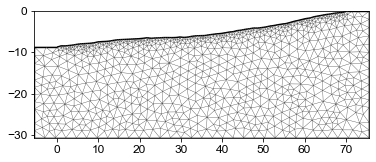

In [2]:
%matplotlib inline
ertData = ert.load('fielddataline2.dat')
ertData['a'] = ertData['a']+1
ertData['b'] = ertData['b']+1
ertData['m'] = ertData['m']+1
ertData['n'] = ertData['n']+1
ert1 = ert.ERTManager(ertData)
grid = ert1.createMesh(data=ertData,quality=30,paraDX=0.5, paraMaxCellSize=3, boundaryMaxCellSize=3000,
                       smooth=[2, 2], paraBoundary=5.5, paraDepth = 22.0)
ert1.setMesh(grid)
mesh = ert1.fop.paraDomain
mesh.setCellMarkers(np.ones((mesh.cellCount()))*2)
pg.show(mesh)
ttData = tt.load("srtfieldline2.dat") # You can change the data file name
TT = pg.physics.traveltime.TravelTimeManager()
TT.setMesh(mesh)

17/06/22 - 00:10:33 - pyGIMLi - ERROR - <class 'pygimli.physics.traveltime.TravelTimeManager.TravelTimeManager'>.checkError(C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\pygimli\physics\traveltime\TravelTimeManager.py:87)
DataContainer has no "err" values. Fallback to 3%
17/06/22 - 00:10:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Create gradient starting model. 500: 5000
17/06/22 - 00:10:33 - pyGIMLi - INFO - Created startmodel from forward operator: [0.00117311 0.00190304 0.00149736 ... 0.00024324 0.00023144 0.00020321]
17/06/22 - 00:10:33 - pyGIMLi - INFO - Starting inversion.
17/06/22 - 00:10:33 - pyGIMLi - INFO - Setting starting model as reference!


fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x000002070B864D10>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000002070C0CC680>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002070D144B80>
min/max (data): 0.0048/0.064
min/max (error): 3%/3%
min/max (start model): 2.0e-04/0.0020
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 9.42 (dPhi = 35.96%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 7.83 (dPhi = 14.48%) lam: 50.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 7.79 (dPhi = 1.42%) lam: 50.0
################################################################################
#                 Abort criteria reached: dPhi = 1.42 (< 2.0%)         

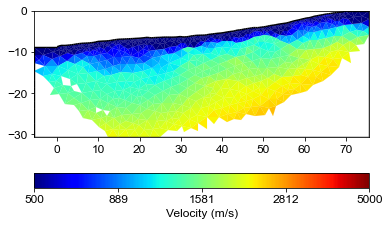

In [3]:

TT.invert(ttData, lam=50,
          zWeight=0.2,vTop=500, vBottom=5000,
          verbose=1, limits=[300., 6000.],isReference=True)

ax, cbar = TT.showResult(cMap='jet',coverage=TT.standardizedCoverage(),cMin=500,cMax=5000)

In [4]:
print(np.mean(abs(TT.inv.response-TT.inv.dataVals)/TT.inv.dataVals))

0.03368356547534474


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x2070b853eb0>)

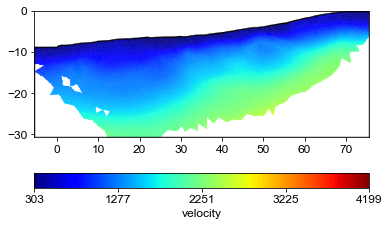

In [5]:
# generate a denser mesh
%matplotlib inline
geo = pg.meshtools.createParaMeshPLC(ertData, quality=34, paraMaxCellSize=0.1,
                                         paraBoundary=5.5,
                                         boundary=0, paraDepth = 22.0)

meshall = pg.meshtools.createMesh(geo,quality=34,area=0.03, smooth=[2, 2], paraBoundary=5.5, paraDepth = 22.0)

out = meshop.linear_interpolation(TT.paraDomain, TT.model.array(), meshall)
out = out.array()
# out = meshop.nearest_neighbor_interpolation(TT.paraDomain, TT.model.array(), meshall)
# out = np.array(out)
Cvout= meshop.nearest_neighbor_interpolation(TT.paraDomain, TT.standardizedCoverage(), meshall)

pg.show(meshall,out,cMap='jet',coverage=Cvout,label='velocity')


In [6]:
meshall.save('fieldvelmesh2')
np.save('fieldVinvmodel2',out)
np.save('fieldVsensmodel2',Cvout)

# meshall = pg.load('fieldvelmesh2.bms')
# out = np.load('fieldVinvmodel2.npy')
# Cvout = np.load('fieldVsensmodel2.npy')

In [7]:
meshall = pg.load('fieldvelmesh2.bms')
out = np.load('fieldVinvmodel2.npy')
Cvout = np.load('fieldVsensmodel2.npy')

In [8]:
%matplotlib auto
pg.show(meshall,out,cMap='jet',coverage=Cvout,label='velocity')

Using matplotlib backend: <object object at 0x0000020757796BB0>


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x20806c6cee0>)

In [9]:
# set up the horizontal position and depth to see the velocity distribution
%matplotlib auto
Xpos = [30,32,35]
Depth =[-25,-25,-25]
xyzpos = CF.sepcificline(meshall,out,Xpos,Depth)

Using matplotlib backend: QtAgg


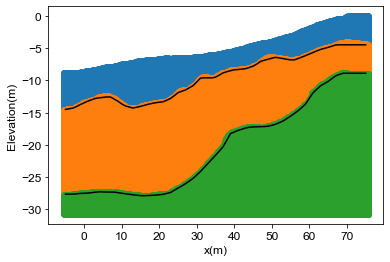

10.962547790762954
12.116254740588145


In [36]:
%matplotlib inline
# select the specific value to do the geophysical zonation
value1 = 1000
value2 = 1950

# set the sections and interval to automatically pick up boundary
firstarea_section = [-5,70]
secondarea_section = [-5,70]
interval = 2

Cvout = np.array(Cvout)
Cvout = np.ones(Cvout.shape)
# set the boundary interpolation range

nrangeinte = np.arange(ttData.sensors().array()[0][0],ttData.sensors().array()[-1][0],1)
nrangeinte = np.hstack((nrangeinte,ttData.sensors().array()[-1][0]))
loc1new,loc2new = CF.boundary(out,Cvout,xyzpos,value1,value2,firstarea_section,secondarea_section,interval,nrangeinte)

np.save('fieldline1_2',loc1new)
np.save('fieldline2_2',loc2new)
# np.save('fieldline2_900',loc1new)
# np.save('fieldline2_1850',loc2new)
print(np.mean(abs(loc1new-loc2new)))
print(np.median(abs(loc1new-loc2new)))

In [11]:
%matplotlib auto
# select the specific value to do the geophysical zonation
value1 = 1100
value2 = 1950

# set the sections and interval to automatically pick up boundary
firstarea_section = [-5,70]
secondarea_section = [-5,70]
interval = 2

Cvout = np.array(Cvout)
Cvout = np.ones(Cvout.shape)
# set the boundary interpolation range

nrangeinte = np.arange(ttData.sensors().array()[0][0],ttData.sensors().array()[-1][0],1)
nrangeinte = np.hstack((nrangeinte,ttData.sensors().array()[-1][0]))
loc1new,loc2new = CF.boundary(out,Cvout,xyzpos,value1,value2,firstarea_section,secondarea_section,interval,nrangeinte)

Using matplotlib backend: QtAgg


In [12]:
np.save('fieldlinex2',nrangeinte)
np.save('fieldline1_2',loc1new)
np.save('fieldline2_2',loc2new)

In [13]:
markerall,meshafter = CF.constraintinvpara(ertData,nrangeinte,loc1new,loc2new,paraBoundary=5.5)
pg.show(meshafter,markerall)
np.save('fieldmarkerall2',markerall)

17/06/22 - 00:11:02 - pyGIMLi - INFO - Save RVector binary
17/06/22 - 00:11:02 - pyGIMLi - INFO - Cache stored: C:\Users\hangchen\AppData\Roaming\pygimli\Cache\16412211765283252503


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x207522013d0>)

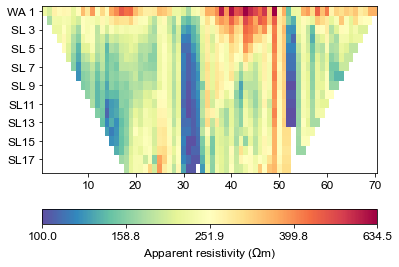

In [14]:
%matplotlib inline
ertData['k'] = ert.createGeometricFactors(ertData, numerical=True)
ertData['rhoa'] = ertData['k']*ertData['u']/ertData['i']

rr = ertData['rhoa']
rr[rr<100]=0

ertData['rhoa'] = rr

ertData.save('test2.dat')
ertData.load('test2.dat')
ert1.checkData(ertData)
ert.show(ertData)


In [15]:
ertData['err'] = ert1.estimateError(ertData, 
                                absoluteUError=0.0000, # 50µV
                                relativeError=0.04)  # 3%

# do the contrained inversion
mgrConstrained = ert.ERTManager()
mgrConstrained.invert(data=ertData, verbose=True, lam=5, mesh=meshafter,limits=[50., 10000.])


# do the uncontrained inversion for comparison
mgrnoConstrained = ert.ERTManager()
mgrnoConstrained.invert(data=ertData, lam=5, paraDepth = 22.0,
                         paraDX=0.5, paraMaxCellSize=5, verbose=True,paraBoundary=5.5,limits=[50., 10000.])


17/06/22 - 00:11:02 - pyGIMLi - INFO - Found 2 regions.
17/06/22 - 00:11:02 - pyGIMLi - INFO - Region with smallest marker (1) set to background
17/06/22 - 00:11:02 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:11:02 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/06/22 - 00:11:02 - pyGIMLi - INFO - Use median(data values)=213.279684147113
17/06/22 - 00:11:02 - pyGIMLi - INFO - Created startmodel from forward operator: 2157 [213.279684147113,...,213.279684147113]
17/06/22 - 00:11:02 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000207521ACAE0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000207521AC860>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x0000020752294F40>
min/max (data): 100/634
min/max (error): 4%/4%
min/max (start model): 213/213
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 2.06 (dPhi = 50.97%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.66 (dPhi = 14.37%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.62 (dPhi = 2.08%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 5 ... 

17/06/22 - 00:11:33 - pyGIMLi - INFO - Found 2 regions.


chi² = 1.62 (dPhi = 0.43%) lam: 5.0
################################################################################
#                 Abort criteria reached: dPhi = 0.43 (< 2.0%)                 #
################################################################################


17/06/22 - 00:11:33 - pyGIMLi - INFO - Region with smallest marker (1) set to background
17/06/22 - 00:11:33 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/06/22 - 00:11:33 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/06/22 - 00:11:33 - pyGIMLi - INFO - Use median(data values)=213.279684147113
17/06/22 - 00:11:33 - pyGIMLi - INFO - Created startmodel from forward operator: 1459 [213.279684147113,...,213.279684147113]
17/06/22 - 00:11:33 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000207B66DB310>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000207B66DB860>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002075761E820>
min/max (data): 100/634
min/max (error): 4%/4%
min/max (start model): 213/213
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 1.86 (dPhi = 52.48%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.67 (dPhi = 6.7%) lam: 5.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.65 (dPhi = 0.94%) lam: 5.0
################################################################################
#                 Abort criteria reached: dPhi = 0.94 (< 2.0%)                 #
#####################

1459 [338.8018827867614,...,165.88874946878713]

0.03109985109748548

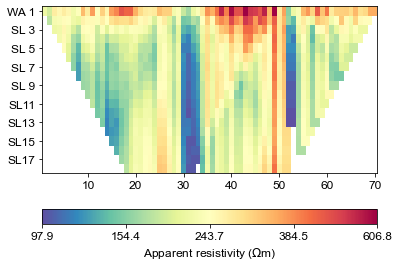

In [16]:
ert.show(ertData,mgrConstrained.inv.response)
np.mean(abs(ertData['rhoa'] - mgrConstrained.inv.response)/(ertData['rhoa']))

(<AxesSubplot:xlabel='x (m)', ylabel='z (m)'>,
 <matplotlib.colorbar.Colorbar at 0x207b6a4a0d0>)

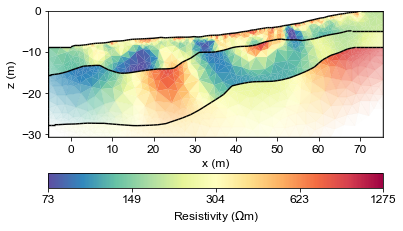

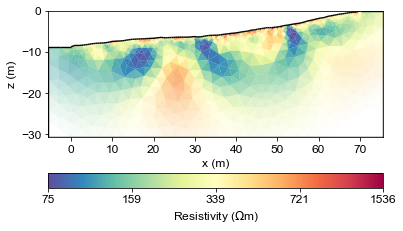

In [17]:
%matplotlib inline
mgrConstrained.showResult(xlabel="x (m)", ylabel="z (m)",coverage = mgrConstrained.coverage())
mgrnoConstrained.showResult(xlabel="x (m)", ylabel="z (m)",coverage = mgrnoConstrained.coverage())

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x207b72ca760>)

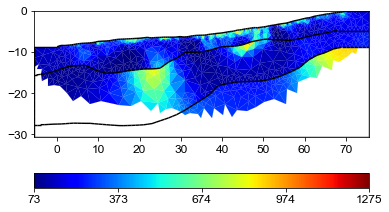

In [18]:
%matplotlib inline
Mall = np.array(mgrConstrained.paraModel())
sens = mgrConstrained.coverage()
mgrConstrained.paraDomain.save('fieldconstaintmesh2')
np.save('fieldconstaintmodel2',Mall )
np.save('fieldconstaintsens2',sens)
sens[sens<-1.3]=-10000
# pg.show(mgrConstrained.paraDomain,sens,cMap='jet')
pg.show(mgrConstrained.paraDomain,Mall,cMap='jet',coverage=sens)

(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x207b67eadc0>)

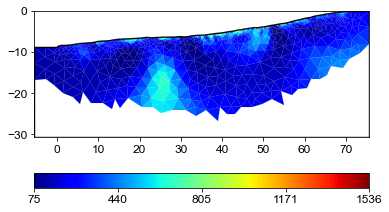

In [19]:
%matplotlib inline
Mall2 = np.array(mgrnoConstrained.paraModel())
sens2 = mgrnoConstrained.coverage()
mgrnoConstrained.paraDomain.save('fieldnoconstaintmesh2')
np.save('fieldnoconstaintmodel2',Mall2)
np.save('fieldnoconstaintsens2',sens2)
np.save('fieldmarkerall2',markerall)
sens2[sens2<-1.3]=-10000
# pg.show(mgrnoConstrained.paraDomain,sens2,cMap='jet')
pg.show(mgrnoConstrained.paraDomain,Mall2,cMap='jet',coverage=sens2)


## MC sampling for water content¶¶
You can start directly here if you already have resistivity inversion results

In [20]:
noconstaintmesh = pg.load('fieldnoconstaintmesh2.bms')
noconstaintmodel = np.load('fieldnoconstaintmodel2.npy')
noconstaintsens = np.load('fieldnoconstaintsens2.npy')

constaintmesh = pg.load('fieldconstaintmesh2.bms')
constaintmodel = np.load('fieldconstaintmodel2.npy')
constaintsens = np.load('fieldconstaintsens2.npy')

markerall = np.load('fieldmarkerall2.npy')

In [21]:
print(constaintmesh.cellCount())

markerall2 = markerall[markerall!=1].copy()
markerall2.shape

2157


(2157,)

In [22]:
petrorange = petroship.petrorange
# petrorange.porosity = [0.45, 0.3, 0.1, 0.35, 0.02, 0.1]
# petrorange.m_model = [1.4, 2.2, 1.0, 1.5, 1.6, 2.5]
petrorange.porosity = [0.5, 0.25, 0.3, 0.2, 0.05, 0.15]
petrorange.n_model = [2.2, 1.3, 2.2, 2.0, 2.0, 2.0]
petrorange.rhos = [100/2, 500/2, 330/2, 700/2, 650/2, 2000/2]
petrorange.sigmas = [1/400, 1/3200, 0, 0, 0, 0]

petrorange.a_model = 1.0

iter1 = 10000





In [23]:
modelsall,modelsall2 = CF.petroMC(iter1, constaintmesh.cellCount(),
           petrorange,markerall,constaintmodel)

C:\Users\hangchen\Documents\Hang\couple\Hydrogeo_inv_seq\test2\petrorelationship.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  solution = np.array(solution)
C:\Users\hangchen\Documents\Hang\couple\Hydrogeo_inv_seq\test2\petrorelationship.py:52: RuntimeWarning: invalid value encountered in power
  func = lambda SS : sigma_sat[i]*SS**n[i] + sigma_sur[i]*SS**(n[i]-1) - 1/rho[i]
C:\Users\hangchen\Anaconda3\envs\pg\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [24]:

tradmodelsall,tradmodelsall2 = CF.petroMCtt(iter1,noconstaintmesh.cellCount(),petrorange,noconstaintmodel)


0.0661782251292667


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x207fcef8eb0>)

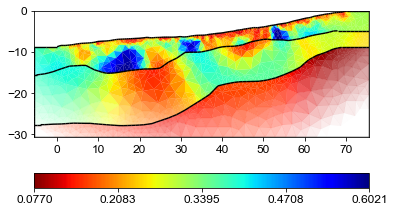

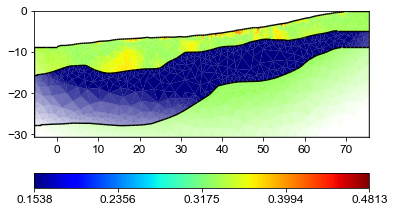

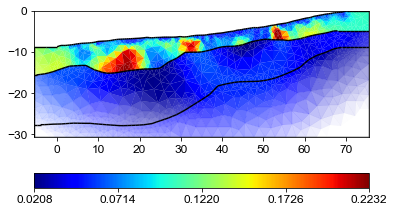

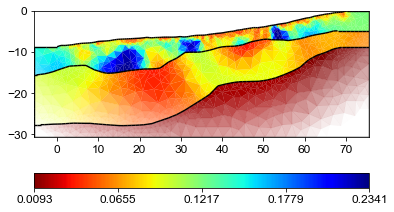

In [25]:
pg.show(constaintmesh,np.mean(modelsall,axis=0),cMap='jet_r',coverage=constaintsens)
pg.show(constaintmesh,np.std(modelsall,axis=0)/np.mean(modelsall,axis=0),cMap='jet',coverage=constaintsens)
pg.show(constaintmesh,np.std(modelsall,axis=0),cMap='jet',coverage=constaintsens)
print(np.mean(np.std(modelsall,axis=0)))
np.mean(np.std(modelsall,axis=0)/np.mean(modelsall,axis=0))
np.save('fieldconstaintWC2',modelsall)

pg.show(constaintmesh,np.mean(modelsall*modelsall2,axis=0),cMap='jet_r',coverage=constaintsens)

0.08828489221663927


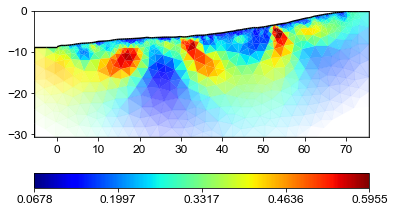

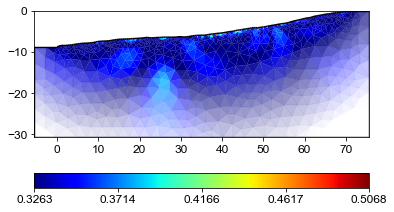

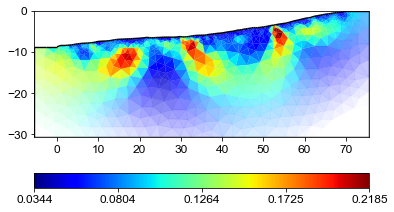

In [26]:
pg.show(mgrnoConstrained.paraDomain,np.mean(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
pg.show(mgrnoConstrained.paraDomain,np.std(tradmodelsall,axis=0)/np.mean(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
pg.show(mgrnoConstrained.paraDomain,np.std(tradmodelsall,axis=0),cMap='jet',coverage=noconstaintsens)
print(np.mean(np.std(tradmodelsall,axis=0)))
np.mean(np.std(tradmodelsall,axis=0)/np.mean(tradmodelsall,axis=0))
np.save('fieldnoconstaintWC2',tradmodelsall)

In [27]:
np.save('fieldnoconstaintWC2',tradmodelsall)